In [40]:
import pandas as pd
import numpy as np
import json
import calendar
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import cluster, preprocessing, metrics
from sklearn.manifold import TSNE
from collections import Counter

from geotext import GeoText
from datetime import datetime, timedelta
%matplotlib inline

# ==== LOCATION BASED CHALLENGE (LBC) ====

The concept of this approach is to take user location data (if available) and try to build a challenge option based on the location data available.

Google maps user location history is enabled by default and running in the background, so it's reasonable to assume this data is readily available.

Some things to consider when deciding to include an LBC are:
- Date of last location : for now, the null hypothesis/assumption about the user's ability to retain their own location information is that they will be able to recall where they were with reasonable accuracy for up to three days worth of history. This assumption will need to be tested and will need to be updated accordingly in effort to improve the location recollection success rate over time.
- If the data is a pair of geographic coordinates but no specific business/name reference, is there user history with reference to any businesses or other frequent markers that can be tied to the user? 
    - eg: have a pair of coordinates for the corner of Washington and Hill. There is a subway, chinese restaurant, mcdonalds, courthouse, and maker city LA/General Assembly. Is there user history to suggest which one (or more) of these were visited by the user? 

## Source : Google Maps Data

In [47]:
# Added new data available from 11/07

g_loc_hist2_raw = pd.read_json('LocationHistory-20161107.json')

# Alternative for updated location data imported on 11/21
#g_loc_hist2_raw = pd.read_json('LocationHistory-20161121.json')


In [48]:
gmaps_columns = ['timestamp','lat','lng','acc','vel','heading','altitude','v_acc']

In [49]:
# Google maps location does not include the decimal point. 
# The code below is to set the offset programmatically in 
# case there is a need to do so in the future. 

gmaps_coord_disp = 10.**7

In [50]:
def pandify_gloc_data(data, columns, geodisp = 10.**7):
    loc_hist = []
        
    for datapoint in data:
        try:
            timestamp = datetime.fromtimestamp((int(datapoint['timestampMs'])/1000)).strftime('%Y-%m-%d %H:%M:%S')
        except:
            timestamp = ''
        try:
            lat = datapoint['latitudeE7']/(geodisp)
        except:
            lat = '0'
        try:
            lng = datapoint['longitudeE7']/(geodisp)
        except:
            lng = '0'
        try:
            alt = datapoint['altitude']
        except:
            alt = '0'
        try:
            v_acc = datapoint['verticalAccuracy']
        except:
            v_acc = '0'
        try:
            vel = datapoint['velocity']
        except:
            vel = '0'
        try:
            heading = datapoint['heading']
        except:
            heading = '0'
        try:
            acc = datapoint['accuracy']
        except:
            acc = '0'

        loc_hist.append([timestamp, lat, lng, acc, vel, heading, alt, v_acc])
    
    return pd.DataFrame(loc_hist, columns=columns)

###  ------------ LBC Subsection - EDA - Dimension Validation ---------------

It may be conceptually logical that user location history is a predictable pattern, we need to verify that there is enough of a pattern upon which we can base one this dimension of user behavior. One such method is to inspect the data by plotting the geolocation points over a series of actual-data plots as well as scaled/clustered plots. If the visualizations show that there is no reasonable clustering of data points or that the user's location history is too "sparse" (that is, the user's location is too erratic to determine a location pattern), then it would be reasonable to conclude that user location is not a viable dimension of user behavior modeling.

In [51]:
gloc_hist_alt = pandify_gloc_data(g_loc_hist2_raw['locations'],gmaps_columns,gmaps_coord_disp)

In [52]:
gloc_hist_alt.head(4)

,timestamp,lat,lng,acc,vel,heading,altitude,v_acc
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,0,63,16
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,0,0
2,2016-11-07 17:23:39,34.036402,-118.308978,10,2,238,58,24
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,0,0


In [53]:
try:
    gloc_hist_alt = gloc_hist_alt[(gloc_hist_alt['timestamp'] > datetime.now() - timedelta(days=14))]
except:
    pass 

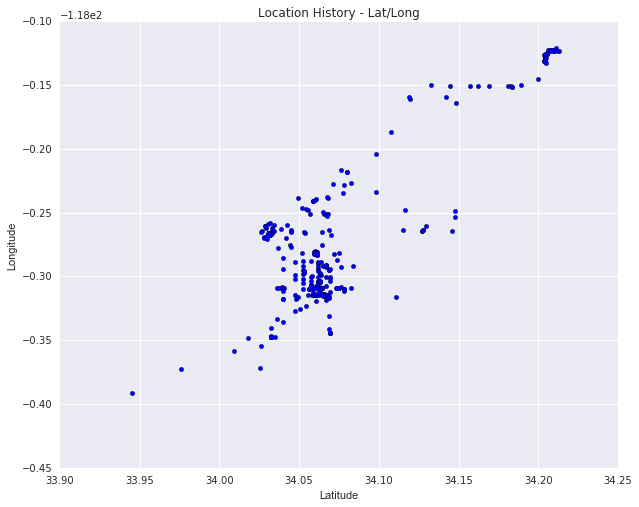

In [54]:
# Rough scatter plot

plt.figure(figsize=(10,8))
plt.scatter(gloc_hist_alt['lat'],gloc_hist_alt['lng'])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Location History - Lat/Long")

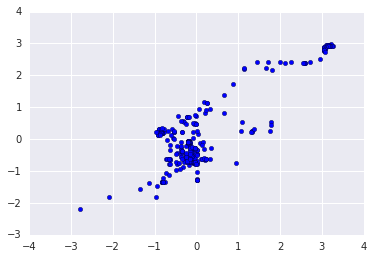

In [55]:
# Re-scaled scatter plot

plt.scatter(preprocessing.scale(np.array(gloc_hist_alt['lat'])), \
            preprocessing.scale(np.array(gloc_hist_alt['lng'])))

In [56]:
geoc = np.array(gloc_hist_alt[['lat','lng']])

In [57]:
kmlist = []

for n in range(2,100):
    lkm = KMeans(n_clusters=n)
    ltkm = lkm.fit(geoc)
    ltkm_score = metrics.silhouette_score(geoc, ltkm.labels_, metric='euclidean')
    kmlist.append([n,ltkm_score])

In [58]:
klist = np.array(kmlist)

In [59]:
np.amax(klist[(klist[:,1]<0.75),1])

0.71274632330211507

In [60]:
for n in klist:
    if n[1]==np.amax(klist[(klist[:,1]<0.75),1]):
        n_max =n[0]
        sc_max = np.amax(klist[(klist[:,1]<0.75),1])
        print "n-cluster matching max sil score : %s"%n[0]

n-cluster matching max sil score : 51.0


(0.5, 0.75)

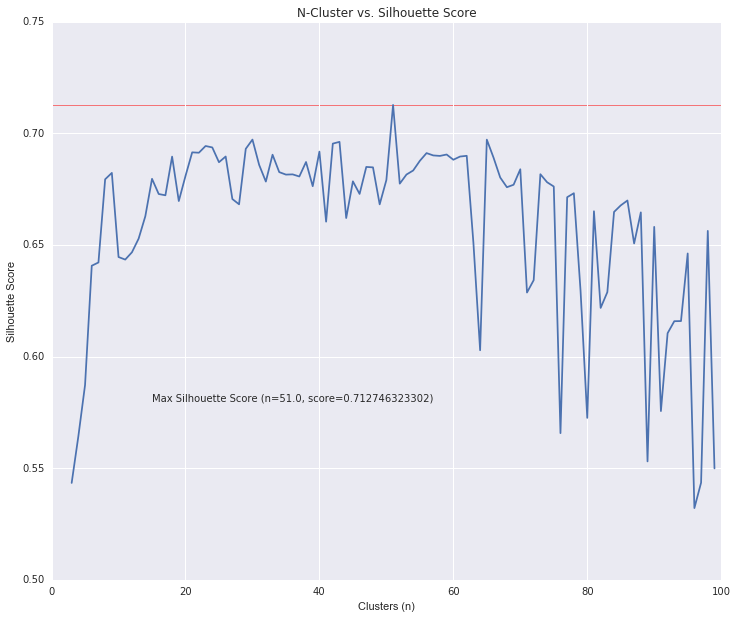

In [61]:
plt.figure(figsize=(12,10))
plt.plot(klist[1:,0],klist[1:,1])
plt.axhline(y=sc_max,c="red",linewidth=0.5,zorder=0)
plt.annotate('Max Silhouette Score (n=%s, score=%s)'%(n_max,sc_max), xy=(n_max, sc_max), xytext=(15, 0.58))
plt.title("N-Cluster vs. Silhouette Score")
plt.xlabel("Clusters (n)")
plt.ylabel("Silhouette Score")
plt.ylim(.5, .75)

In [62]:
lkm = KMeans(n_clusters=int(n_max))

In [63]:
ltkm = lkm.fit(geoc)

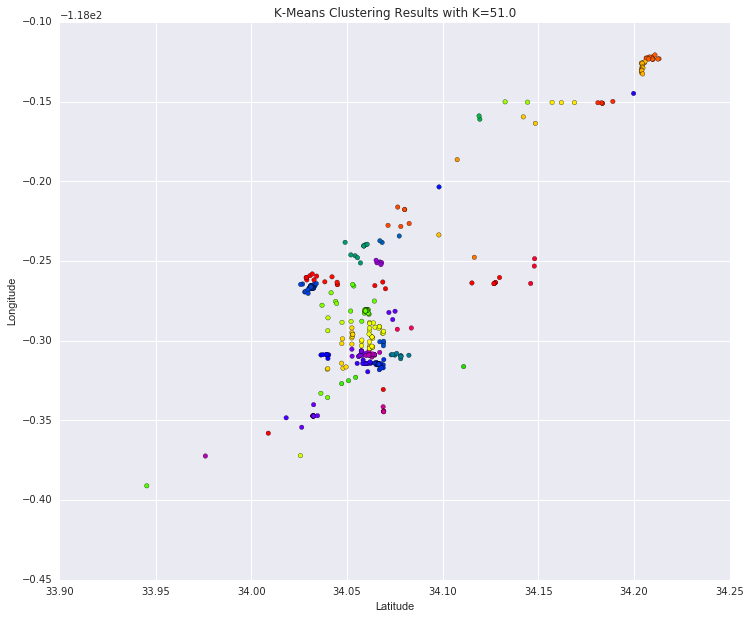

In [64]:
plt.figure(figsize=(12,10))
plt.scatter(geoc[:,0], geoc[:,1], c=ltkm.labels_, cmap=plt.cm.prism) 
plt.title("K-Means Clustering Results with K=%s"%n_max)
#plt.scatter(ltkm.cluster_centers_[:,0], ltkm.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")


In [65]:
my_tsne = TSNE(n_components=2)
geoc_stand = StandardScaler().fit_transform(geoc)
loc_tsne = my_tsne.fit_transform(geoc_stand)
loc_tsne_df = pd.DataFrame({'X1':loc_tsne[:,0], 'X2':loc_tsne[:,1],'y':ltkm.labels_})

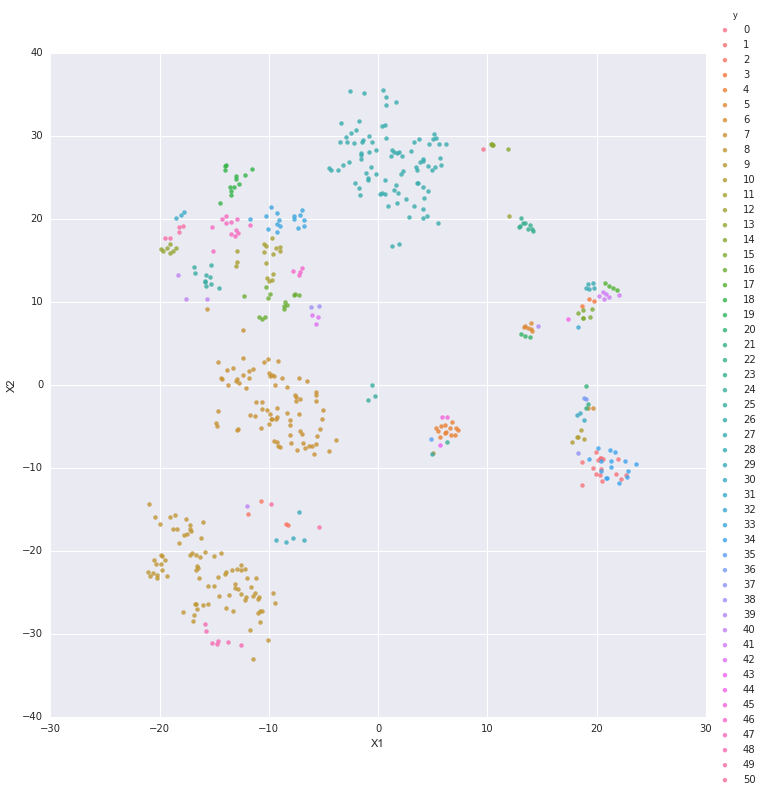

In [66]:
import seaborn as sns

sns.lmplot('X1','X2',data=loc_tsne_df, fit_reg=False,hue='y', size=10)

In [67]:
print "Dataset Start: %s"%gloc_hist_alt.tail(1)['timestamp'].values
print "Dataset Finish: %s"%gloc_hist_alt.head(1)['timestamp'].values

Dataset Start: ['2016-10-28 08:33:21']
Dataset Finish: ['2016-11-07 18:07:21']


### Section Conclusion

Though it may seem like a relatively high optimal 'n' given the number of data points, it is not outside the realm of reason that a user may have been located that many number of places over the timeframe of the data (11 days). 

Given that the points represent actual locations, the interpretation of the scatterplot is that during the observation period, the user traveled mainly between two points, but spent a lot of time in places inbetween the two points. The TSNE plot reveals that of the locations, there may be specific points of interest within the overall location data. 

This is ideal as we can work towards identifying those points of interest (POI) that the user may have a higher chance of recalling correctly. An "insignificant datapoint" (ie: data collected while the user was either in transit or sitting in traffic) which although could be considered a predictor of user behavior (ie: during evening commute, there amy be a point in the travel path in which there may be excessive traffic), may not be a particular point of interest for generating an LBC. User may not be able to easily recall the answer to "Where are you usually located at around XX:XX AM/PM?" if that location is a particular intersection. If a location is known/trained such as "home" or the name of the company where they work, the user may be more likely to recall the correct answer.

###  ------------ END of LBC Subsection - EDA - Dimension Validation ---------------

###  ------------ LBC Subsection - EDA - Finding POI ---------------

In [68]:
# For the purposes of placing the user at a specific time, we will not need the velocity and heading. 
# For now, we will keep accuracy and vertical accuracy figures.

In [69]:
gloc_hist_alt = gloc_hist_alt.drop(['vel'], axis=1).drop(['altitude'], axis=1)

In [70]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0


In [71]:
gloc_hist_alt['poi_id'] = ltkm.labels_

In [72]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc,poi_id
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,27
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,27
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,13
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,8
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10,8
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6,8
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0,8
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20,48
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16,25
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0,27


Based on the following degree precision information (Source: Wikipedia, https://en.wikipedia.org/wiki/Decimal_degrees), add locations with reduced accuracy within reasonable tolerances for clustering options.

![title](gps-resolution.png)

In [73]:
gloc_hist_alt['lat4'] = [round(glat,4) for glat in gloc_hist_alt['lat']]
gloc_hist_alt['lng4'] = [round(glng,4) for glng in gloc_hist_alt['lng']]
gloc_hist_alt['lat5'] = [round(glat,5) for glat in gloc_hist_alt['lat']]
gloc_hist_alt['lng5'] = [round(glng,5) for glng in gloc_hist_alt['lng']]

In [74]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc,poi_id,lat4,lng4,lat5,lng5
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,27,34.0664,-118.3148,34.06639,-118.31478
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,27,34.0664,-118.3148,34.06639,-118.31476
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,13,34.0364,-118.3090,34.03640,-118.30898
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,8,34.0312,-118.2659,34.03123,-118.26590
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10,8,34.0314,-118.2657,34.03140,-118.26572
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6,8,34.0313,-118.2665,34.03133,-118.26653
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0,8,34.0314,-118.2666,34.03138,-118.26662
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20,48,34.0328,-118.2619,34.03281,-118.26194
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16,25,34.0525,-118.2983,34.05251,-118.29826
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0,27,34.0664,-118.3148,34.06642,-118.31479


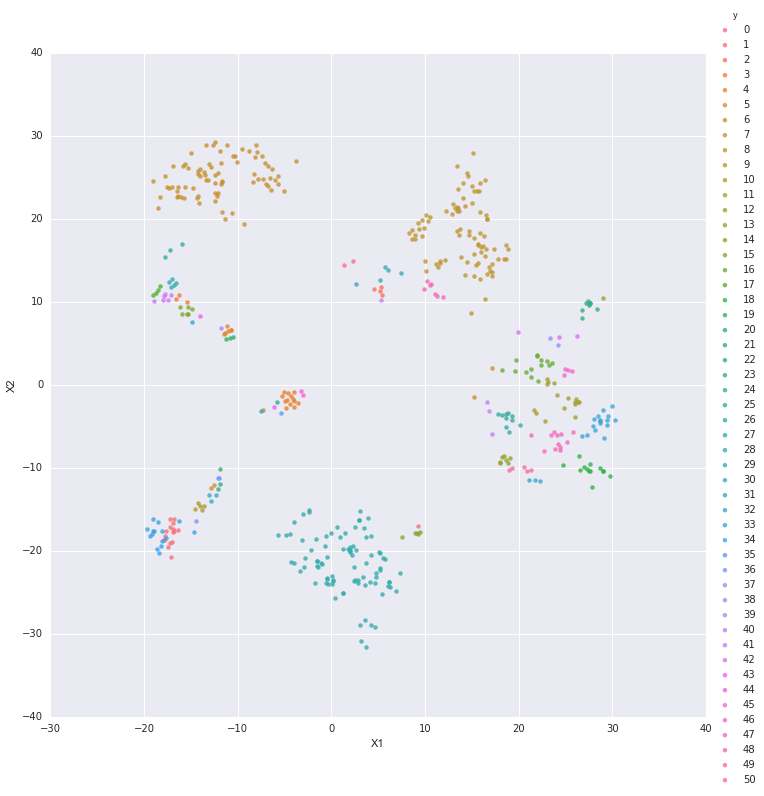

In [75]:
gloc4_tsne = TSNE(n_components=2)
geoc4_stand = StandardScaler().fit_transform(gloc_hist_alt[['lat4','lng4']])

loc4_tsne = gloc4_tsne.fit_transform(geoc4_stand)
loc4_tsne_df = pd.DataFrame({'X1':loc4_tsne[:,0], 'X2':loc4_tsne[:,1],'y':ltkm.labels_})

sns.lmplot('X1','X2',data=loc4_tsne_df, fit_reg=False,hue='y', size=10)

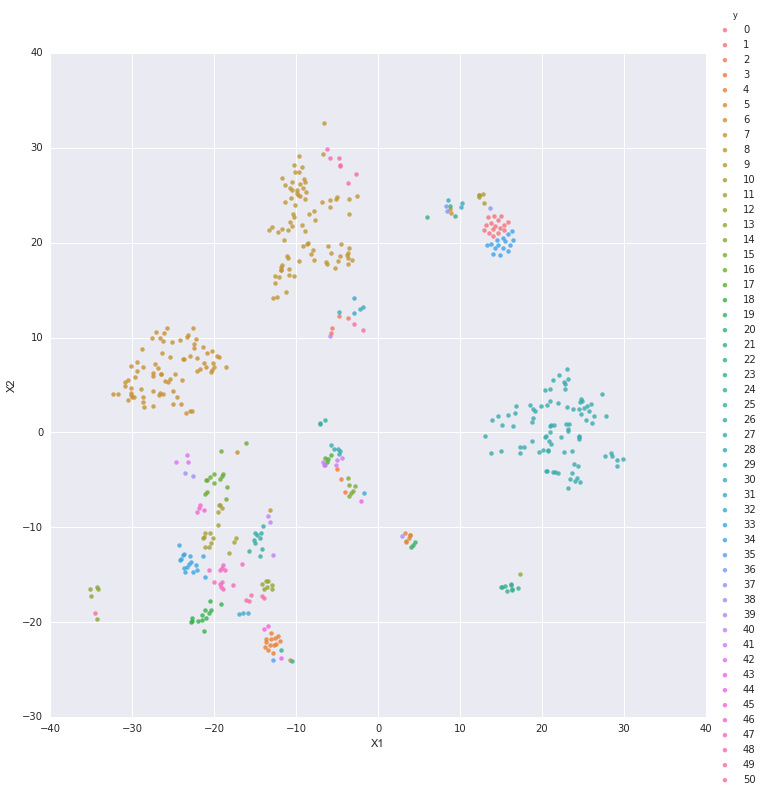

In [76]:
gloc5_tsne = TSNE(n_components=2)
geoc5_stand = StandardScaler().fit_transform(gloc_hist_alt[['lat5','lng5']])

loc5_tsne = gloc5_tsne.fit_transform(geoc5_stand)
loc5_tsne_df = pd.DataFrame({'X1':loc5_tsne[:,0], 'X2':loc5_tsne[:,1],'y':ltkm.labels_})

sns.lmplot('X1','X2',data=loc5_tsne_df, fit_reg=False,hue='y', size=10)

In [77]:
poi_id_list = gloc_hist_alt['poi_id'].value_counts().to_frame(name='Count').reset_index()

In [78]:
poi_id_list.head(10)

,index,Count
0,27,89
1,8,84
2,7,80
3,33,16
4,11,16
5,1,16
6,34,15
7,16,14
8,4,13
9,18,13


In [79]:
poi_sig = poi_id_list['Count'].describe()

In [80]:
poi_sig

count    51.000000
mean      9.843137
std      19.376659
min       1.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      89.000000
Name: Count, dtype: float64

In [81]:
min_sig = poi_sig.ix['mean']+poi_sig.ix['std']

if len(poi_id_list[(poi_id_list['Count']>min_sig)]['index'].values) < 2:
    min_sig = poi_sig.ix['mean']+poi_sig.ix['std']
else:
    min_sig = poi_sig.ix['mean']+(poi_sig.ix['std']*2)

In [82]:
poi_sig.ix['mean']+poi_sig.ix['std']

29.219795944180248

In [83]:
min_sig

48.596454633458535

In [84]:
poi_id_list[(poi_id_list['Count']>min_sig)]['index']

0    27
1     8
2     7
Name: index, dtype: int64

In [85]:
poi_points = poi_id_list[(poi_id_list['Count']>min_sig)]['index'].values

In [86]:
if len(poi_points)<2:
    min_sig = poi_sig.ix['mean']+poi_sig.ix['std']
    poi_points = poi_id_list[(poi_id_list['Count']>min_sig)]['index'].values

poi_points

array([27,  8,  7])

In [87]:
# The value counts of the POI id's shows us there are three locations in particular that may be of 
# high interest to the user. 

In [88]:
def showmap(maplat,maplng,zoom=16):

    from IPython.display import IFrame
    from IPython.core.display import display

    # Google Maps URL template for an iframe

    maps_url = "http://maps.google.com/maps?q={0}+{1}&z={2}&output=embed&iwloc=near".format(maplat,maplng,zoom)
#    maps_url = "http://maps.googleapis.com/maps/api/staticmap?center={0},{1}&size=400x300&zoom=14".format(maplat,maplng)
#    maps_url = "https://www.google.com/maps/embed?pb={0}+{1}&z={2}&output=embed".format(maplat,maplng,zoom)

#    print maps_url

    display(IFrame(maps_url, '400px', '300px'))

In [89]:
# Sample Geographic Location Visualization

#for n in poi_id_list[:5]['index']:
for n in poi_points:

    mean_lat = gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['lat'].mean()
    mean_lng = gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['lng'].mean()

    print mean_lat,mean_lng
    showmap(mean_lat,mean_lng)

34.0664876966 -118.314874163


34.0311754976 -118.266346281


34.0601805 -118.281154637


###  ------------ END of LBC Subsection - EDA - Finding POI ---------------

In [90]:
gloc_hist_alt['timestamp'] = pd.to_datetime(gloc_hist_alt['timestamp'])
gloc_hist_alt['dotw'] = [gldt.dayofweek for gldt in gloc_hist_alt['timestamp']]
gloc_hist_alt['hotd'] = [gldt.hour for gldt in gloc_hist_alt['timestamp']]

In [91]:
gloc_hist_alt.head(4)

,timestamp,lat,lng,acc,heading,v_acc,poi_id,lat4,lng4,lat5,lng5,dotw,hotd
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,27,34.0664,-118.3148,34.06639,-118.31478,0,18
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,27,34.0664,-118.3148,34.06639,-118.31476,0,18
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,13,34.0364,-118.3090,34.03640,-118.30898,0,17
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,8,34.0312,-118.2659,34.03123,-118.26590,0,14


In [93]:
pd.DataFrame(gloc_hist_alt[(gloc_hist_alt['poi_id']==4)]['hotd'].describe())

,hotd
count,13.000000
mean,20.923077
std,1.255756
min,19.000000
25%,20.000000
50%,21.000000
75%,22.000000
max,23.000000


In [96]:
# Build a DataFrame of the basic stats values using the .describe method for each of the
# datetime frequency based columns in the poi dataframe. 

poi_dotw_df_list = []

for n_poi in range(0,len(poi_points)):
    poi_dotw_df_list.append(gloc_hist_alt[(gloc_hist_alt['poi_id']==poi_points[n_poi])]['dotw'].describe().values)

In [97]:
poi_freq_cols = ['count','mean','std','min','25p','50p','75p','max']

In [98]:
poi_freq_df = pd.DataFrame(poi_dotw_df_list,columns=poi_freq_cols, index=[poi_points])

In [99]:
dayfreq_list = []
cols = ['weekday_visits','weekend_visits','weekday_only','weekend_only']

for poi_loc in poi_points:
    
    on_weekends = []
    on_weekdays = []
    visit_weekends = []
    visit_weekdays = []
    weekdays_only = []
    weekends_only = []
    weekdays = (0,1,2,3,4)
    weekends = (5,6)
    
    for dotw in gloc_hist_alt[(gloc_hist_alt['poi_id']==poi_loc)]['dotw'].value_counts().index:
        if dotw in weekends:
            on_weekends.append(dotw)
        if dotw in weekdays:
            on_weekdays.append(dotw)

    visit_weekends.append(len(on_weekends)==0)
    visit_weekdays.append(len(on_weekdays)==0)
    weekdays_only.append((len(on_weekends)==0) & (len(on_weekdays)>0))
    weekends_only.append((len(on_weekdays)==0) & (len(on_weekends)>0))
    
    dayfreq_list.append([on_weekdays,on_weekends,weekdays_only,weekends_only])

poi_dayfreq_df = pd.DataFrame(dayfreq_list, columns=cols,index=[poi_points])

In [100]:
poi_dayfreq_df['weekday_only'] = [item[0] for item in poi_dayfreq_df['weekday_only']]
poi_dayfreq_df['weekend_only'] = [item[0] for item in poi_dayfreq_df['weekend_only']]

In [102]:
poi_main_df = pd.concat([poi_freq_df, poi_dayfreq_df], axis=1)

In [103]:
poi_main_df

,count,mean,std,min,25p,50p,75p,max,weekday_visits,weekend_visits,weekday_only,weekend_only
27,89.0,3.988764,2.053237,0.0,2.0,5.0,6.0,6.0,"[4, 2, 0, 1, 3]","[6, 5]",False,False
8,84.0,1.892857,1.456335,0.0,1.0,2.0,3.0,4.0,"[1, 0, 4, 3, 2]",[],True,False
7,80.0,5.462500,0.940559,0.0,5.0,6.0,6.0,6.0,"[1, 0]","[6, 5]",False,False


In [104]:
selected_poi_for_freq_query = poi_freq_df['std'].idxmin()

most_freq_dotw_for_pot = gloc_hist_alt[(gloc_hist_alt['poi_id']==selected_poi_for_freq_query)]['dotw'].value_counts().index[0]

print "The POI ID of the location with the highest recollection potential is:", selected_poi_for_freq_query
print "The user most commonly visits the POI with HRP on:",calendar.day_name[most_freq_dotw_for_pot]
if poi_main_df['weekday_only'].ix[selected_poi_for_freq_query]:
    print "This POI occurs only on weekdays"
elif poi_main_df['weekend_only'].ix[selected_poi_for_freq_query]:
    print "This POI occurs only on weekends"

The POI ID of the location with the highest recollection potential is: 7
The user most commonly visits the POI with HRP on: Sunday


# =============== END LBC ================

# ======= LBC Generation ========

This is a rough implementation of the Location Based Challenge module for SG1. 

Expected final implementation will be a LBC class which will include measures to destroy the instance after use or upon expiration so that data does not reside in memory. 

In [107]:
# Password tokenization

import time
import hashlib
import random

testdev = '06883575783776600' # Add copy of first digit to create 16-digit key

token = 'a'

valid_answer = []

def tokemon(devid = testdev):
    to_encode = devid + str(int(round(time.time())))
    encoded = hashlib.sha224(to_encode).hexdigest()
    global token
    token = encoded
    return token

In [111]:
# Version 0.1 - Basic LBC generation based on assumed data from above. 

# No parameters
# Data is assumed to inherently exist from processing/model applications above.
# This version of LBC is basing geolocation information solely from GPS coordinates
# obtained via Google Maps background locator data.

# Function will return LBC with hint if available along with randomized token for answer tokenization. 

# Secondary function will take LBC challenge answer and token and repond with authentication response. 
import warnings
warnings.filterwarnings('ignore')

def genlbc(qtype='geo'):
    
    # There are different "classes" of location oriented questions that can be generated based
    # on user location behavior modeling. 
    
    # Location Frequency - What day(s) are you usually at {%location}?
    # Significant POI - On {%dotw}, where do you go most often? 

    global valid_answer
    valid_answer = []

    if qtype=='geo':
        hint = "none"
        question = "What day(s) do you visit this place/area most often? "
        if poi_main_df['weekday_only'].ix[selected_poi_for_freq_query]==True:
            global valid_answer
            valid_answer.append('weekdays')
        elif poi_main_df['weekend_only'].ix[selected_poi_for_freq_query]==True:
            global valid_answer
            valid_answer.append('weekends')
        valid_answer.append(calendar.day_name[most_freq_dotw_for_pot].lower())
            
        challenge = [question, hint]
        gen_token = tokemon()

        return challenge, gen_token
    else:
        return False

In [112]:
def passlbc(answer,passed_token):
    
    if passed_token != token:
        return 0
    else:
        global valid_answer
        if answer in valid_answer:
            return 1
        if answer not in valid_answer:
            return -1

In [113]:
# Test function to query user and try authenticating.
import string


def lbc_auth(method='geoloc'):

    if method=='geoloc':
        mean_lat = gloc_hist_alt[(gloc_hist_alt['poi_id']==selected_poi_for_freq_query)]['lat'].mean()
        mean_lng = gloc_hist_alt[(gloc_hist_alt['poi_id']==selected_poi_for_freq_query)]['lng'].mean()
        
        print valid_answer
        
        lbc_query,lbc_token = genlbc('geo')
        for attempt_number in range(0,3):
            if attempt_number > 0:
                try:
                    if lbc_query[1]!="none":
                        print lbc_query[0]
                        raw_response = raw_input(hint)
                    else:
                        raw_response = raw_input(lbc_query[0])
                except:
                    raw_response = raw_input(lbc_query[0])
            else:
                showmap(mean_lat,mean_lng)
                raw_response = raw_input(lbc_query[0])            
            response = raw_response.lower().translate(None, string.punctuation)
            attempt = passlbc(response,lbc_token)
            if attempt==1:
                print "Login OK - You have been identified as an authorized user."
                break
            elif attempt==-1:
                print "Authenticated failed. Please try again."
            elif attempt==0:
                print "Insecure authentication attempt detected. System may be compromised."
                break
        if (attempt_number==2) and (attempt != 1):
            print "Access Denied."
    else:
        print "Other methods in progress"

## === LBC Tests ===

In [115]:
lbc_auth('geoloc')

['sunday']


What day(s) do you visit this place/area most often? sunday
Login OK - You have been identified as an authorized user.
